In [4]:
import numpy as np

from skimage.transform import probabilistic_hough_line
from skimage.util import view_as_windows

from collections import namedtuple
import math
import random

from skimage.morphology import dilation, disk, square
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import itertools
import functools
from skimage import filters, img_as_ubyte, img_as_float
from skimage import transform, exposure
from sklearn import metrics
from tqdm.notebook import tqdm
from skimage.measure import label, regionprops
from matplotlib import pyplot as plt

In [5]:
random.seed(10)
np.random.seed(10)

In [66]:
Point = namedtuple('Point', 'x y')
Segment = namedtuple('Segment', 'point_0, point_1, length')
points_dist = lambda pt_0, pt_1 : math.sqrt((pt_0.x-pt_1.x)**2 + (pt_0.y-pt_1.y)**2)
segment_angle = lambda segment : math.atan2((segment.point_1.y-segment.point_0.y), (segment.point_1.x-segment.point_0.x)) #* 180 / math.pi

In [67]:
def norm_counts(counts, weights):
    """
        This function returns a set of normalized counts, based on the weights of bins
    """
    weights = [i/ min(weights) for i in weights]
    counts_norm = [list(itertools.repeat(count, int(weight)))  for count, weight in zip(counts, weights)]
    return functools.reduce(lambda x1, x2 : x1+x2, counts_norm) 

In [137]:
def joint_filter(image):
    """
        This function takes a centerline image (numpy array) and replace joints with 0
    """
    image = img_as_float(image)
    coords = []
    corner_tpl = np.array([[1, 0, 1], [0, 0, 0], [1, 0, 1]])
    edge_tpl = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
    for i in range(image.shape[0]-1):
        for j in range(image.shape[1]-1):
            if i > 1 and j > 1:
                kernel = image[i-1:i+2, j-1:j+2]
                if kernel[1, 1] == 1:
                    if np.sum(kernel)>=5:
                        coords.append(np.asarray([i, j]))
                        image[i, j] = 0
                    elif np.sum(kernel*corner_tpl)>=3 or np.sum(kernel*edge_tpl)>=3:
                        image[i, j] = 0
                    elif np.sum(kernel*corner_tpl)==2 and np.sum(kernel*edge_tpl)==1:
                        image[i, j] = 0
                    elif np.sum(kernel*corner_tpl)==1 and np.sum(kernel*edge_tpl)==2:
                        image[i, j] = 0
    return np.vstack(coords) if len(coords)>0 else np.array([]), img_as_ubyte(image)

def smooth_mask(mask, smooth_sigma=2):
    density = exposure.rescale_intensity(filters.gaussian(
                                                            dilation(mask, 
                                                            footprint=disk(1)), 
                                                            sigma=smooth_sigma, 
                                                            preserve_range=False), 
                                        out_range=(0, 1))
    return density

def compute_feats(test_patch, smooth_sigma=2):
    """
        This function takes a centerline image (numpy array) and return centerline features and individual fragments
    """
    # compute cirvar, cirmean, lenvar, lenmean, num_segs, alignment coefficient (normalized)
    test_patch = test_patch.copy()
    lines = probabilistic_hough_line(test_patch, threshold=1, line_length=2, line_gap=0, seed=0)
    angles = []
    lengths = []
    joints, filtered = joint_filter(test_patch)
    labeled = label(filtered, connectivity=2)
    regions = regionprops(labeled)
    line_lengths = np.asarray([region.area for region in regions if region.area>3])
    for line in lines:
        p0, p1 = line # (x1, y1), (x2, y2)
        if p0[0]<=p1[0]:
            point_0 = Point(p0[0], p0[1])
            point_1 = Point(p1[0], p1[1])
        if p0[0]>p1[0]:
            point_1 = Point(p0[0], p0[1])
            point_0 = Point(p1[0], p1[1])
        segment = Segment(point_0, point_1, points_dist(point_0, point_1))
        angles.append(segment_angle(segment))
        lengths.append(segment.length)
        
    density = smooth_mask(test_patch)
    if len(lines)>0:
        angles_norm = norm_counts(angles, lengths)
        cirmean = stats.circmean(angles_norm, high=math.pi/2, low=-math.pi/2)
        cirvar = stats.circvar(angles_norm, high=math.pi/2, low=-math.pi/2)
        lenmean = np.mean(line_lengths) + joints.shape[0]/np.count_nonzero(test_patch)
        lenvar = np.var(line_lengths/lenmean)
        intensity = np.count_nonzero(test_patch)
        feats = {'cir_mean' : cirmean, 'cir_var' : cirvar, 'len_mean' : lenmean, 'len_var' : lenvar, 'intensity' : intensity, 'density' : density}
    else:
        feats = {'cir_mean' : 1, 'cir_var' : 1, 'len_mean' : 1, 'len_var' : 1, 'intensity' : 1, 'density' : density}
    return feats, regions

In [98]:
def image_to_feats(edges, window_size=128, step_factor=8):
    """
        This function takes a large centerline image (numpy array), view as windows, invoke compute_feats, and return centerline features in a list.
    """
    edges = edges.copy()
    edges_padded = np.pad(edges, pad_width=(int(window_size/2), int(window_size/2)), mode='reflect')
    sequence_patches = view_as_windows(edges_padded, 
                                        window_shape=(window_size, window_size), 
                                        step=(int(window_size/step_factor), 
                                        int(window_size/step_factor))
                                        )
    feats = []
    for i in range(sequence_patches.shape[0]):
        for j in range(sequence_patches.shape[1]):
            test_patch = sequence_patches[i, j]
            feats.append(compute_feats(test_patch))
    return feats, (sequence_patches.shape[0], sequence_patches.shape[1])

In [117]:
def iou(mask_1, mask_2, beta=1e-3, soft=False):
    """
        This function computes a (soft) IoU of two input masks.
    """
    if soft:
        union = mask_1**2 + mask_2**2 - mask_1*mask_2
        intersection = mask_1 * mask_2
    else:
        union = np.logical_or(mask_1, mask_2)
        intersection = np.logical_and(mask_1, mask_2)
    ratio = (intersection.sum()+beta)/(union.sum()+beta)
    return ratio, union, intersection


def norm_feats(vecs):
    """
        This function normalize the features to 0-1.
    """
    vecs_1 = vecs.copy()
    for col in range(vecs_1.shape[1]):
        vecs_1[:, col] = exposure.rescale_intensity(vecs_1[:, col], out_range=(0, 1))
    return vecs_1

In [111]:
def centerline_similarity(centerlines_1, centerlines_2, window_size=128, step_factor=8):
    feats_1, shape = image_to_feats(centerlines_1, window_size=window_size, step_factor=step_factor)
    feats_2, _ = image_to_feats(centerlines_2, window_size=window_size, step_factor=step_factor)
    iou_scores = []
    vecs_1 = []
    vecs_2 = []
    for feat_1, feat_2 in zip(feats_1, feats_2):
        vec_1 = np.array( [ feat_1[k] for k in list(feat_1.keys())[:-1] ])
        vec_2 = np.array( [ feat_2[k] for k in list(feat_2.keys())[:-1] ])
        vec_1 = np.nan_to_num(vec_1)
        vec_2 = np.nan_to_num(vec_2)
        vecs_1.append(vec_1)
        vecs_2.append(vec_2)
        iou_scores.append(iou(feat_1['density'], feat_2['density'], soft=True))
    vecs_1 = np.vstack(vecs_1)
    vecs_2 = np.vstack(vecs_2)
    vecs_1_norm = norm_feats(vecs_1)
    vecs_2_norm = norm_feats(vecs_2)
    sims = []
    for vec_1, vec_2 in zip(vecs_1_norm, vecs_2_norm): 
        sim = metrics.pairwise.cosine_similarity(vec_1.reshape(1, -1), vec_2.reshape(1, -1))
        # sim = metrics.mean_squared_error(vec_1.reshape(1, -1), vec_2.reshape(1, -1)) * (vec_1[-1]+vec_2[-1])/2
        sims.append(sim)
    # sims = exposure.rescale_intensity( np.array([max(sims)-i for i in sims]), out_range=(0, 1))
    canvas = np.zeros(shape[0]*shape[1])
    for idx, item in enumerate(sims):
        canvas[idx] = 0.0*item + 1.0*iou_scores[idx]
    canvas = canvas.reshape(shape)
    canvas = 1- transform.resize(canvas, (int(shape[0]*window_size/step_factor), int(shape[1]*window_size/step_factor)))
    return canvas[:centerlines_1.shape[0], :centerlines_1.shape[1]]

In [112]:
feats_1, shape = image_to_feats(image_1, window_size=128, step_factor=8)

In [113]:
image_1 = io.imread('Michael.tif')
image_2 = io.imread('Bin.tif')

In [114]:
results = centerline_similarity(image_1, image_2, window_size=64, step_factor=8)

In [115]:
io.imsave('test-soft.tif', img_as_ubyte(results))

In [126]:
ratio, U, I = iou(smooth_mask(image_1), smooth_mask(image_2), soft=True)

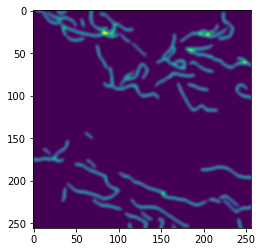

In [127]:
plt.imshow(U)

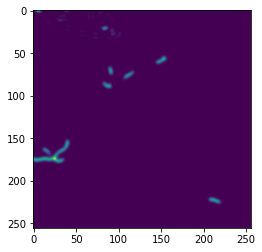

In [128]:
plt.imshow(U-I)

In [138]:
features, regions = compute_feats(image_1)

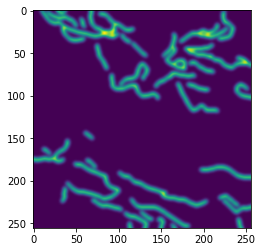

In [139]:
plt.imshow(features['density'])

In [140]:
region = regions[0]

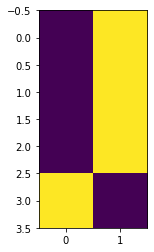

In [151]:
plt.imshow(regions[8].image)